Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [54]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
import pickle
import os.path
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [2]:
model_folder = 'data/model/'
trajectory_folder = 'data/trajectory/'
optimal_trajectory_folder = 'data/optimal_trajectory/'

---
# 2 - Robot modelling

## Create joint variables and define their relations

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9 = new_sym('q:10')
# define paralelogram coordinate relation
# q3 = -q2 + q4
# q5 = -q4 + q2

## Robot geometry definition in following order

| Joint number | previous link | successive links | $a$ | $\alpha$ | $d$ | $\theta$ |
|--------------|---------------|------------------|-----|----------|-----|----------|

In [6]:
# robot_def = RobotDef([(0,   -1, [1],    0, 0, 0, 0),
#                       (1,   0,  [2, 4], 0, 0, -0.21537, q1),
#                       (2,   1,  [3],    0, -sympy.pi/2, 0, q2+sympy.pi/2),
#                       (3,   2,  [],    0.279, 0, 0, q3+sympy.pi/2),
#                       (4,   1,  [5],    0, -sympy.pi/2, 0, q4+sympy.pi),
#                       (5,   4,  [],     0.1, 0, 0, q5-sympy.pi/2)],
#                      dh_convention='mdh',
#                      friction_type=['Coulomb', 'viscous', 'offset'])

robot_def = RobotDef([(0,   -1, [1],    0,      0,              0,          0),
                      (1,   0,  [2],    0,      0,              -0.21537,   q1),
                      (2,   1,  [3],    0,      -sympy.pi/2,    0,          q2+sympy.pi/2),
                      (3,   2,  [4],    0.279,  0,              0,          q3 + sympy.pi / 2)],
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous', 'offset'])

In [7]:
robot_def.coordinates

In [8]:
robot_def.std_params

In [9]:
robot_def.bary_params

## Create kinematics chain

In [10]:
geom = Geometry(robot_def)


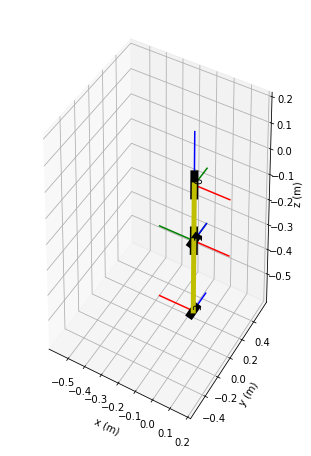

In [55]:
geom.draw_geom()

In [12]:
geom.T_0nc[1]

⎡                      l1x⋅cos(q₁)   l1y⋅sin(q₁)⎤
⎢cos(q₁)  -sin(q₁)  0  ─────────── - ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                      l1x⋅sin(q₁)   l1y⋅cos(q₁)⎥
⎢sin(q₁)  cos(q₁)   0  ─────────── + ───────────⎥
⎢                           m₁            m₁    ⎥
⎢                                               ⎥
⎢                            l1z                ⎥
⎢   0        0      1        ─── - 0.21537      ⎥
⎢                             m₁                ⎥
⎢                                               ⎥
⎣   0        0      0              1            ⎦

## Create dynamics object


In [13]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating joint torques...
Adding frictions...
Joint 0 type: A
Joint 1 type: R
dq1_da0 = 1, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
dq1_da1 = 0, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
dq1_da2 = 0, tau_f = Fc1*sign(dq1) + Fo1 + Fv1*dq1
Joint 2 type: R
dq2_da0 = 0, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
dq2_da1 = 1, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
dq2_da2 = 0, tau_f = Fc2*sign(dq2) + Fo2 + Fv2*dq2
Joint 3 type: R
dq3_da0 = 0, tau_f = Fc3*sign(dq3) + Fo3 + Fv3*dq3
dq3_da1 = 0, tau_f = Fc3*sign(dq3) + Fo3 + Fv3*dq3
dq3_da2 = 1, tau_f = Fc3*sign(dq3) + Fo3 + Fv3*dq3
Calculating gregressor...
Calculating M, C and G...
Calculating base parameter...
base parameter number: 24
Creating H_b function...
Finished creating robot dynamics
CPU times: user 1min 18s, sys: 231 ms, total: 1min 19s
Wall time: 1min 18s


In [15]:
dyn._calc_base_param()

Calculating base parameter...
base parameter number: 24
Creating H_b function...


In [16]:
sympy.Matrix(dyn.base_param)

⎡             1.0⋅l3y              ⎤
⎢                                  ⎥
⎢             1.0⋅L3xy             ⎥
⎢                                  ⎥
⎢             1.0⋅l3x              ⎥
⎢                                  ⎥
⎢             1.0⋅L3yz             ⎥
⎢                                  ⎥
⎢             1.0⋅l2y              ⎥
⎢                                  ⎥
⎢             1.0⋅L3xz             ⎥
⎢                                  ⎥
⎢        1.0⋅l2x + 0.279⋅m₃        ⎥
⎢                                  ⎥
⎢             1.0⋅L2xy             ⎥
⎢                                  ⎥
⎢             1.0⋅L3zz             ⎥
⎢                                  ⎥
⎢  1.0⋅L1zz + 1.0⋅L2xx + 1.0⋅L3xx  ⎥
⎢                                  ⎥
⎢             1.0⋅L2yz             ⎥
⎢                                  ⎥
⎢       1.0⋅L2xz - 0.279⋅l3z       ⎥
⎢                                  ⎥
⎢-1.0⋅L2xx + 1.0⋅L2yy + 0.077841⋅m₃⎥
⎢                                  ⎥
⎢             1.0⋅Fv₃              ⎥
⎢

---
# 3 - Excitation trajectory optimization

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [17]:
base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(dyn, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)])
traj_optimizer.optimize()

joint constraint number: 2
cartisian constraint number: 0
constraint number: 8
Condition number: 22.3814326532
x: [ 0.07261533  0.2876235   0.17153063 -0.30791305  0.33339829  0.7310084
 -0.14156879  0.1595815  -0.22717356 -0.1339295   0.53258853 -0.59503202
 -0.6186507   0.29854836  0.16661836  0.51242586  0.82318143  0.60177383
 -0.64074101 -0.37683899  0.64993773 -0.02211353  0.42714546  0.85746915
  0.51136373 -0.29375049 -0.83914971 -0.98056539  0.43393494 -0.32012352
  0.12220733 -0.06082132  0.02057602  0.33532122  0.81913643 -0.7451352
  0.329045    0.34968672 -0.29308306]

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   11.1071
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:
        Name        Value        Optimum
	     f         22.3814             0

	Variables (c - 

## Plot optimal excitation trajectory

('traj:', 0)
('traj:', 1)
('traj:', 2)


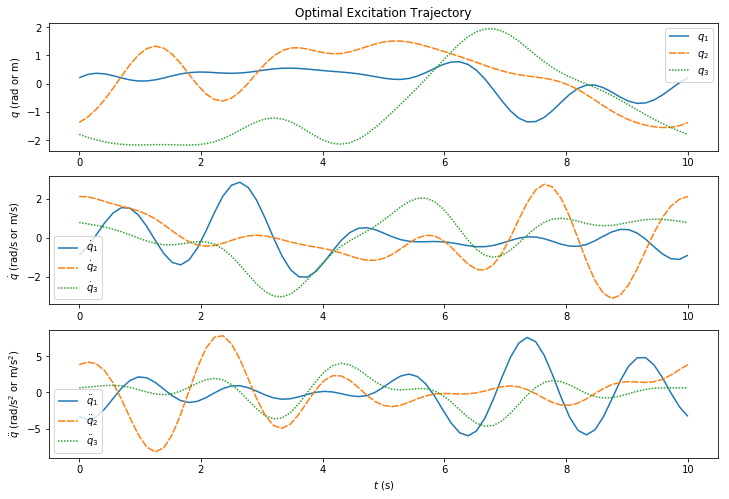

In [56]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

## Save trajectory for later use

In [19]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)


In [20]:
dof_order_bf_x_file_name = 'optimal_traj1.pkl'
dof_order_bf_x_dir = optimal_trajectory_folder + dof_order_bf_x_file_name

#if not os.path.exists(dof_order_bf_x_dir):
with open(dof_order_bf_x_dir, 'wr') as f:
    pickle.dump(dyn.H_b, f)

---
# Data processing

In [21]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [22]:
trajectory_data_file = trajectory_folder + 'test.csv'
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(trajectory_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [23]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


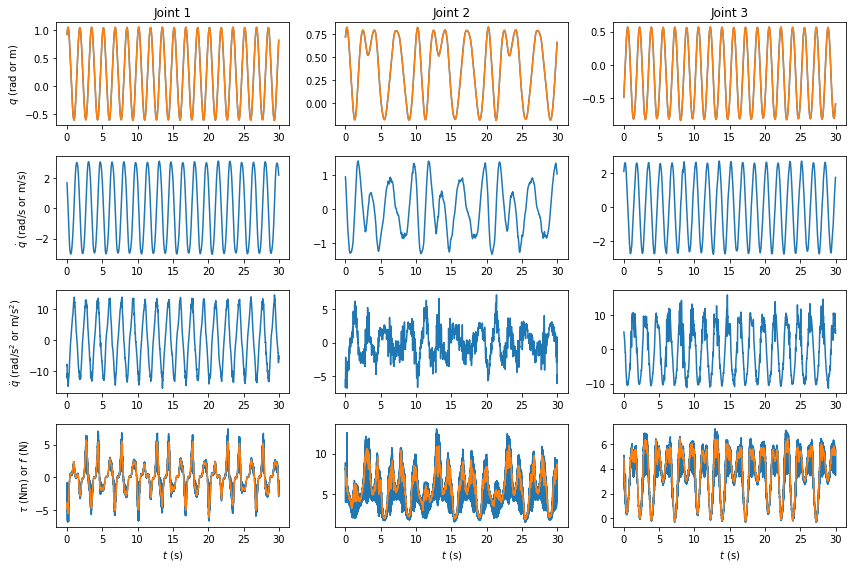

In [57]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [25]:
traj_optimizer.x_result

array([ 0.07261533,  0.2876235 ,  0.17153063, -0.30791305,  0.33339829,
        0.7310084 , -0.14156879,  0.1595815 , -0.22717356, -0.1339295 ,
        0.53258853, -0.59503202, -0.6186507 ,  0.29854836,  0.16661836,
        0.51242586,  0.82318143,  0.60177383, -0.64074101, -0.37683899,
        0.64993773, -0.02211353,  0.42714546,  0.85746915,  0.51136373,
       -0.29375049, -0.83914971, -0.98056539,  0.43393494, -0.32012352,
        0.12220733, -0.06082132,  0.02057602,  0.33532122,  0.81913643,
       -0.7451352 ,  0.329045  ,  0.34968672, -0.29308306])

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [26]:
base_param_num = dyn.base_num
H_b_func = dyn.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [27]:
print(W_b.shape, tau_s.shape)

((17970, 24), (17970,))


In [28]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/yan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [30]:
sympy.Matrix.hstack(sympy.Matrix(dyn.base_param), sympy.Matrix(xb_ols))

⎡             1.0⋅l3y                 0.0744451512660678  ⎤
⎢                                                         ⎥
⎢             1.0⋅L3xy                -0.0204855925496507 ⎥
⎢                                                         ⎥
⎢             1.0⋅l3x                  0.444294094117089  ⎥
⎢                                                         ⎥
⎢             1.0⋅L3yz                0.00147247321324049 ⎥
⎢                                                         ⎥
⎢             1.0⋅l2y                 0.0309348191578381  ⎥
⎢                                                         ⎥
⎢             1.0⋅L3xz               -0.000341120353469338⎥
⎢                                                         ⎥
⎢        1.0⋅l2x + 0.279⋅m₃            0.844444821276343  ⎥
⎢                                                         ⎥
⎢             1.0⋅L2xy                0.00164920211520655 ⎥
⎢                                                         ⎥
⎢             1.0⋅L3zz                 0

## Compare measured torque and predicted torque

### Generate predicted torque

In [31]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]

### Evaluate regression

In [32]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0022703017412518825
standard deviation of xb using OLS:
[2.31706662e-04 7.64830648e-05 3.64499428e-04 1.85197569e-04
 1.78212285e-03 9.37242263e-05 8.03845900e-04 1.82110740e-04
 1.35617274e-04 1.65905695e-04 2.60397695e-04 1.97527572e-04
 4.67085477e-04 1.15913319e-03 7.37232175e-04 1.68171811e-03
 1.13801480e-04 4.86407231e-04 3.13981530e-03 6.15787727e-04
 1.71759174e-02 1.35500993e-03 1.40336021e-03 1.55554016e-03]
percentage of standard deviation of xb using OLS: 
[0.00311245 0.00373351 0.0008204  0.12577313 0.05760896 0.27475413
 0.00095192 0.11042354 0.00103644 0.00338564 0.40630079 0.55591482
 0.00177764 0.07443275 0.28425867 0.0588114  0.00073408 0.00268109
 0.04651468 0.09667674 0.17232203 0.15458806 0.08618206 0.15323904]


### Plot measured torque and predicted torque

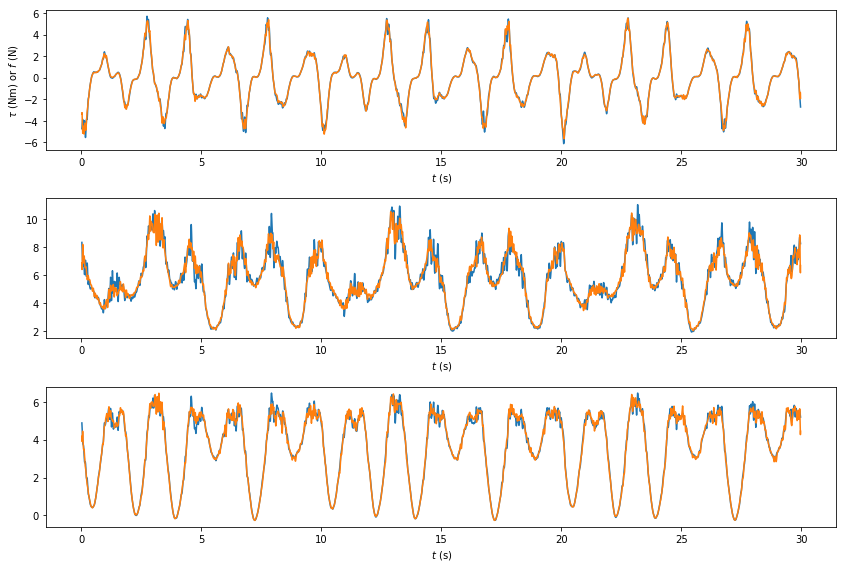

In [58]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

## Convex optimization

In [35]:
# #from identification import SDPOpt
# import cvxpy as cp

# # sdp_opt = SDPOpt(W_b, tau_s, None)
# # sdp_opt.solve()
# m, n = W_b.shape
# sdp_x = cp.Variable(n)
# sdp_obj = cp.Minimize(cp.sum_squares(W_b*sdp_x - tau_s))
# sdp_constraints = []
# sdp_prob = cp.Problem(sdp_obj, sdp_constraints)

# result = sdp_prob.solve(solver=cp.OSQP)

# print(sdp_x.value)

In [36]:
# xb_ols

### Generate regressor matrix for barycentric parameters

In [37]:
from identification import SDPOpt

bary_param_num = len(robot_def.bary_params)
H_func = dyn.H_func
W, tau_s = gen_regressor(bary_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [39]:
# constraint order: (min_m, max_m, min_x, max_x, min_y, max_y, min_z, max_z)
# sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
#                   (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
#                   (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05),
#                   (0.5, 5, -0.1, 0.1, 0, 0.1, -0.1, 0.1),
#                   (0.1, 1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1),]
sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
                  (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
                  (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05)]

In [43]:
sdp_opt_std = SDPOpt(W, tau_s, robot_def, sdp_constraints)
sdp_opt_std.solve()

Regressor shape: (17970, 39)
Regressand shape: (17970,)
Creating variables...
Creating optimization objective...
Creating constraints...
i_param: 0
i_link: 0
i_param: 13
i_link: 1
i_param: 26
i_link: 2
Solving problem...
[ 7.65896226e+00 -2.10120708e-14  7.44053488e-22  6.12272945e+00
 -4.84816276e-16  3.39179963e-05 -6.13332878e-18  6.70553779e-09
  1.29570196e-08  3.37901136e+00  3.33873168e-03  6.47494505e-03
  6.27971858e-03  3.55053653e-02 -4.05293388e-03 -1.51967213e-02
  1.39664671e-01  2.90524196e-03  1.13550313e-01  2.91918949e-01
 -3.93548962e-02  1.49828497e-01  2.99815679e+00  2.11737976e-02
  1.06816552e-02  5.53079738e-01  1.26416927e-02 -2.11461159e-02
 -1.03171387e-03  1.18406015e-01  1.95451916e-03  1.26378916e-01
  4.34455753e-01  8.36295752e-02 -6.17886172e-02  2.03254367e+00
  2.42997972e-02  4.95561322e-03  1.60361977e-01]


## Compare measured torque and predicted torque

### Generate predicted torque

In [44]:
tau_sdp_p = np.zeros(tau_f.shape)
tau_sdp_ps = W.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_sdp_p[:, i] = tau_sdp_ps[i::dof]

### Plot measured torque and predicted torque

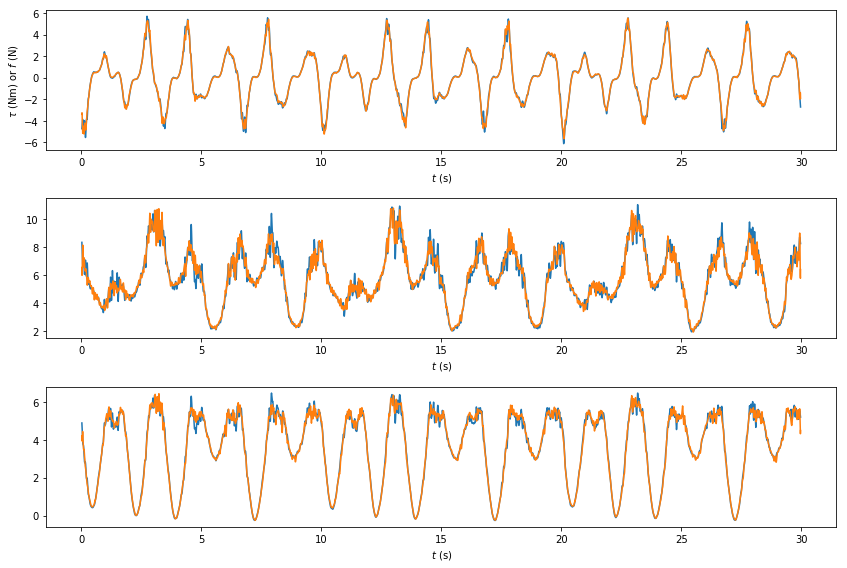

In [59]:
plot_meas_pred_tau(t_cut, tau_f, tau_sdp_p)

In [46]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.bary_params), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx    7.65896225700888   ⎤
⎢                           ⎥
⎢L1xy  -2.10120707876836e-14⎥
⎢                           ⎥
⎢L1xz  7.44053487626697e-22 ⎥
⎢                           ⎥
⎢L1yy    6.12272944962458   ⎥
⎢                           ⎥
⎢L1yz  -4.84816276202236e-16⎥
⎢                           ⎥
⎢L1zz   3.39179963245262e-5 ⎥
⎢                           ⎥
⎢l1x   -6.13332878454513e-18⎥
⎢                           ⎥
⎢l1y    6.70553778855172e-9 ⎥
⎢                           ⎥
⎢l1z    1.29570195869016e-8 ⎥
⎢                           ⎥
⎢ m₁     3.37901135638723   ⎥
⎢                           ⎥
⎢Fc₁    0.00333873167903131 ⎥
⎢                           ⎥
⎢Fv₁    0.00647494505331726 ⎥
⎢                           ⎥
⎢Fo₁    0.00627971857521939 ⎥
⎢                           ⎥
⎢L2xx   0.0355053653015985  ⎥
⎢                           ⎥
⎢L2xy  -0.00405293387646559 ⎥
⎢                           ⎥
⎢L2xz   -0.0151967212842098 ⎥
⎢                           ⎥
⎢L2yy    0.139664671052383  ⎥
⎢         

In [47]:
from identification import barycentric2standard_params

In [48]:
sdp_opt_std.x_result

array([ 7.65896226e+00, -2.10120708e-14,  7.44053488e-22,  6.12272945e+00,
       -4.84816276e-16,  3.39179963e-05, -6.13332878e-18,  6.70553779e-09,
        1.29570196e-08,  3.37901136e+00,  3.33873168e-03,  6.47494505e-03,
        6.27971858e-03,  3.55053653e-02, -4.05293388e-03, -1.51967213e-02,
        1.39664671e-01,  2.90524196e-03,  1.13550313e-01,  2.91918949e-01,
       -3.93548962e-02,  1.49828497e-01,  2.99815679e+00,  2.11737976e-02,
        1.06816552e-02,  5.53079738e-01,  1.26416927e-02, -2.11461159e-02,
       -1.03171387e-03,  1.18406015e-01,  1.95451916e-03,  1.26378916e-01,
        4.34455753e-01,  8.36295752e-02, -6.17886172e-02,  2.03254367e+00,
        2.42997972e-02,  4.95561322e-03,  1.60361977e-01])

In [52]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_def)

In [53]:
sympy.Matrix.hstack(sympy.Matrix(robot_def.std_params), sympy.Matrix(x_std))

⎡I1xx    7.65896225700888   ⎤
⎢                           ⎥
⎢I1xy  -2.10120707876957e-14⎥
⎢                           ⎥
⎢I1xz  7.44029969013466e-22 ⎥
⎢                           ⎥
⎢I1yy    6.12272944962458   ⎥
⎢                           ⎥
⎢I1yz  -4.59103493585291e-16⎥
⎢                           ⎥
⎢I1zz   3.39179963245129e-5 ⎥
⎢                           ⎥
⎢r1x   -1.81512523565554e-18⎥
⎢                           ⎥
⎢r1y    1.98446737264628e-9 ⎥
⎢                           ⎥
⎢r1z    3.83455934896738e-9 ⎥
⎢                           ⎥
⎢ m₁     3.37901135638723   ⎥
⎢                           ⎥
⎢Fc₁    0.00333873167903131 ⎥
⎢                           ⎥
⎢Fv₁    0.00647494505331726 ⎥
⎢                           ⎥
⎢Fo₁    0.00627971857521939 ⎥
⎢                           ⎥
⎢I2xx   0.0275013188477063  ⎥
⎢                           ⎥
⎢I2xy  -0.00788476815221773 ⎥
⎢                           ⎥
⎢I2xz  -0.000608499145543505⎥
⎢                           ⎥
⎢I2yy    0.103754190446675  ⎥
⎢         